# Importação das bibliotecas

In [145]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
from sklearn.model_selection import train_test_split

# Importando Dataset

In [146]:
url = "https://raw.githubusercontent.com/Bruno-Venceslau/dataset-modelos_preditivos/refs/heads/main/student_exam_data_new.csv"
df = pd.read_csv(url)
df.head()

,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Study Hours          500 non-null    float64
 1   Previous Exam Score  500 non-null    float64
 2   Pass/Fail            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [148]:
df.describe()

,Study Hours,Previous Exam Score,Pass/Fail
count,500.000000,500.000000,500.000000
mean,5.487055,68.917084,0.368000
std,2.688196,17.129607,0.482744
min,1.045554,40.277921,0.000000
25%,3.171517,53.745955,0.000000
50%,5.618474,68.309294,0.000000
75%,7.805124,83.580209,1.000000
max,9.936683,99.983060,1.000000


# Dividindo Dataset em Treinamento, normalização e Validação

In [149]:
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 2)
(100, 2)
(400,)
(100,)


In [152]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Preparação dos dados para o PyTorch

In [153]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
y_test_tensor  = torch.FloatTensor(y_test.values).view(-1, 1)

In [154]:
print(y_train_tensor)

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
      

In [155]:
print(X_train_tensor)

tensor([[ 1.1654,  0.4718],
        [-1.3439,  0.1282],
        [-0.7095, -1.1803],
        [ 0.5219, -0.5419],
        [-1.6334, -1.2136],
        [-1.3861, -1.2374],
        [ 0.0919, -1.1729],
        [ 0.4249, -1.1341],
        [ 0.8478, -0.1272],
        [-1.2814,  0.0794],
        [ 0.6648, -0.8593],
        [-0.0314,  1.0842],
        [-1.5455, -0.2440],
        [ 0.9390, -0.0705],
        [ 1.5297, -0.6981],
        [-0.5534,  0.1876],
        [ 1.5447,  0.1905],
        [-1.6003,  1.1426],
        [-1.0588, -0.7393],
        [-1.5666, -0.9075],
        [ 0.5133,  1.5670],
        [ 0.6245, -1.3141],
        [ 0.1516,  1.0946],
        [-0.0479,  0.8944],
        [-0.0039,  1.1355],
        [-0.3695,  1.0682],
        [-0.5845,  1.6023],
        [ 1.3174, -1.2361],
        [ 1.0486, -0.0920],
        [-0.8546, -0.1280],
        [-1.1123,  1.7810],
        [ 1.0156, -1.4197],
        [-1.6408,  0.6093],
        [ 1.0222,  1.2466],
        [ 1.5306, -1.6347],
        [-1.0273, -1

## Construindo Modelo da Rede

In [156]:
model = nn.Linear(2, 1)

In [157]:
model.state_dict()

OrderedDict([('weight', tensor([[ 0.5123, -0.4687]])),
             ('bias', tensor([-0.5433]))])

# Treinamento

### Laço de Treinamneto

In [158]:
lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [159]:
num_epochs = 200
losses = []
losses_test = []
acc_list = []
acc_test_list = []
for epoch in range(num_epochs):
    output = model(X_train_tensor)
    output_test = model(X_test_tensor)

    loss = criterion(output, y_train_tensor)
    loss_test = criterion(output_test, y_test_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    losses_test.append(loss_test.item())

    y_pred_train = torch.sigmoid(output)
    y_pred_test = torch.sigmoid(output_test)

    y_class_train = (y_pred_train >= 0.5).float()
    y_class_test = (y_pred_test >= 0.5).float()

    acc_list.append((y_class_train == y_train_tensor).float().mean())
    acc_test_list.append((y_class_test == y_test_tensor).float().mean())

    if (epoch + 1) % 20 == 0:
         print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

final_loss = loss.item()
print('Final loss:', final_loss)

Epoch[20/200], loss: 0.332461
Epoch[40/200], loss: 0.292553
Epoch[60/200], loss: 0.277547
Epoch[80/200], loss: 0.269866
Epoch[100/200], loss: 0.265359
Epoch[120/200], loss: 0.262493
Epoch[140/200], loss: 0.260574
Epoch[160/200], loss: 0.259238
Epoch[180/200], loss: 0.258284
Epoch[200/200], loss: 0.257586
Final loss: 0.2575863301753998


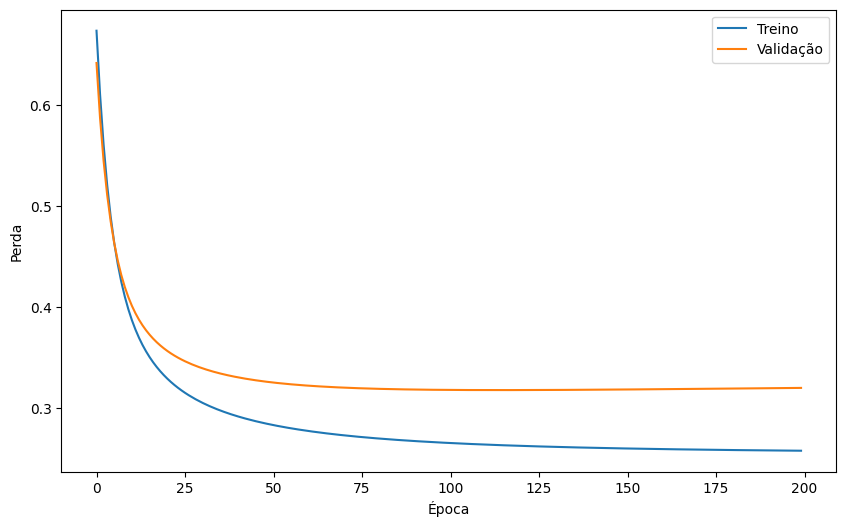

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(num_epochs)), losses, label='Treino')
plt.plot(list(range(num_epochs)), losses_test, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

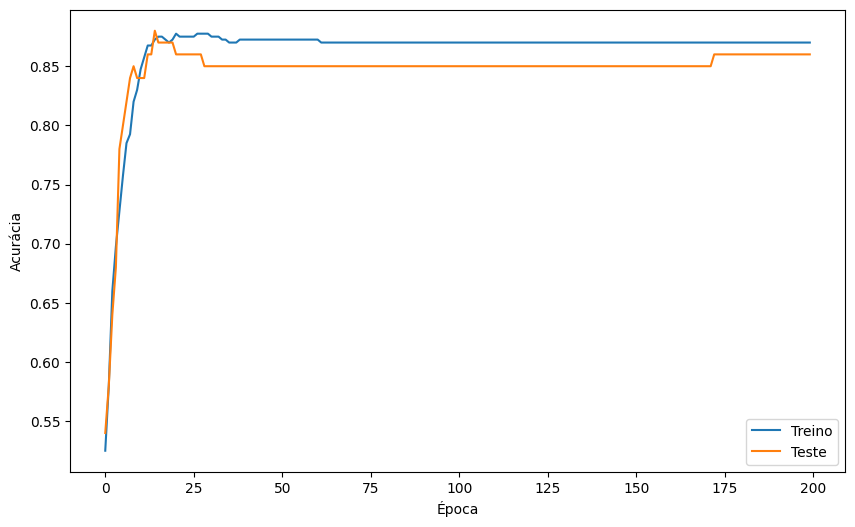

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(num_epochs)), acc_list, label='Treino')
plt.plot(list(range(num_epochs)), acc_test_list, label='Teste')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Avaliação


In [164]:
model.state_dict()

OrderedDict([('weight', tensor([[2.8175, 2.2989]])),
             ('bias', tensor([-1.4089]))])

## Salvando os parâmetros treinados

In [165]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/modelo_binario.pt')

## Recuparando Pesos Salvos

In [166]:
param_saved = torch.load('models/modelo_binario.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight', tensor([[2.8175, 2.2989]])),
             ('bias', tensor([-1.4089]))])

## Exatidão (acurácia) do classificador

In [167]:
y_pred_train = torch.sigmoid(model(X_train_tensor))
y_pred_test = torch.sigmoid(model(X_test_tensor))


y_class_train = (y_pred_train >= 0.5).float()
y_class_test = (y_pred_test >= 0.5).float()


acc_train = (y_class_train == y_train_tensor).float().mean()
acc_test = (y_class_test == y_test_tensor).float().mean()

print(f"\nAcurácia no treino: {acc_train.item():.4f}")
print(f"Acurácia no teste:  {acc_test.item():.4f}")


Acurácia no treino: 0.8700
Acurácia no teste:  0.8600
